Modelling code for finding interesting relationships between P Sonic logs and various other well curves.

Written by Corey Morgan - Land Seismic Noise Specialists
2022

First step is to import the various python modules we will need to run the code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import petropy as ptr
import welly
import lasio
import glob             #library for finding files
import os               #library for interacting with files
import re               #library for regular expressions
from glob import glob
from scipy import signal
from scipy.fftpack import fft, fftshift
from scipy.optimize import curve_fit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d
from sklearn.linear_model import BayesianRidge

#Set options
pd.set_option('display.max_columns', None)
%matplotlib notebook
welly.__version__

'0.4.9'

In [2]:
def pow_law(x, a, b):
    return a*np.power(x,b)

def line_solve(x, a, b):
    return (a*x)+b

def poly2(x, a, b, c):
    return a*np.power(x,2) + b*x + c

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }


Below is where we create a list of files to be used.

In [51]:
#files = glob('teapot\*.las')
#files = glob('2018\*.las')
#files = glob('2016\*.las')
#files = glob('viking_graben_wells\*.las')
#files = glob('all\*.las')
#files = glob('bpx\*.las')
#files = glob('misc\*.las')
files = glob('misc2\*.las')
#files = glob('GBDS\*.las')

print(files)


['misc2\\100000574077_10163.las', 'misc2\\100000709150_10162.las', 'misc2\\100000747336_10164.las', 'misc2\\1045139052.las', 'misc2\\1045139656.las', 'misc2\\1045140017.las', 'misc2\\1045146223.las', 'misc2\\1045146228.las', 'misc2\\1045146263.las', 'misc2\\1045365162.las', 'misc2\\1045365365.las', 'misc2\\1045386420.las', 'misc2\\1045399712.las', 'misc2\\1045399827.las', 'misc2\\1045400044.las', 'misc2\\1045400162.las', 'misc2\\1045628015.las', 'misc2\\1045628082.las', 'misc2\\1045628142.las', 'misc2\\1045628150.las', 'misc2\\1045637383.las', 'misc2\\1045637402.las', 'misc2\\1045637876.las', 'misc2\\1045637990.las', 'misc2\\1045649974.las', 'misc2\\1045649987.las', 'misc2\\1045649988.las', 'misc2\\1045663159.las', 'misc2\\1046076336.las', 'misc2\\1046076340.las', 'misc2\\1046088348.las', 'misc2\\1046088631.las', 'misc2\\1046101782.las', 'misc2\\1046102025.las', 'misc2\\1046102119.las', 'misc2\\1046102129.las', 'misc2\\1046102132.las', 'misc2\\1046102441.las', 'misc2\\1046102465.las', 

The following cell reads in each las file and parses out the proper curves.  It then runs a median filter on each curve to eliminate spikes and other extraneous data and appends the curves to a pandas data frame.  Currently, we are reading:

Neutron Porosity
Sonic
Bulk Density
Gamma Ray

In [52]:

print(len(files),'LAS files found.')

nphi_alias = ['NPHI','NEUT','CNPOR','NPOR']


depth_alias = ['DEPT','DEPTH','M_DEPTH','DPTH','DEPT:1','MD','DEPTH:1','DEPTH_HOLE','BDEP',
    'DMEA','TOTAL_DEPTH','TVD','DEP','TDEP','DEPTMEAS','DEPT_PNN','DEPT_CBL',
    '"DEPTH"','TVD:1','DEP:1']

#Make empty list and dataframe
err_files = []
nphi_df = pd.DataFrame()

#Place files that cause hangups here
hangups = []

#Saveout counter
i = 0
#k is a counter for suitable files
k = 0
#j is a counter for finding suitable logs i.e. those with nphi and dtc
j = 0
#Loop through files
for file in files:
    
    las = lasio.read(file)
    params = {'mnemonic' : [x.mnemonic for x in las.curves],
                  'unit' : [x.unit for x in las.curves]}
                  #'value' : [x.value for x in las.params],
                  #'descr' : [x.descr for x in las.params]}

    
    i += 1
    
    #print(las.well.WELL.value)
    #for item in las.well:
        #print(f"{item.descr} ({item.mnemonic}): {item.value}")
    j=0
    for count, curve in enumerate(las.curves):
        #temp = temp[temp.mnemonic.isin(nphi_alias)]
        #print(temp)
        #print(f"Curve: {curve.mnemonic}, Units: {curve.unit}, Description: {curve.descr}")
        if curve.mnemonic == 'GR' or curve.mnemonic == 'GRN' or curve.mnemonic == 'GRR' or curve.mnemonic == 'GR_BPX_GOLD':
            j += 1
            curve.mnemonic = 'GR'
        if curve.mnemonic == 'NPHI' or curve.mnemonic == 'NPHIL' or curve.mnemonic == 'NEUT' or curve.mnemonic == 'CNPOR':# or curve.mnemonic == 'NPOR' or curve.mnemonic == 'NPHI_BPX_GOLD':
            print(f"Curve: {curve.mnemonic}, Units: {curve.unit}, Description: {curve.descr}")
            j += 1
            curve.mnemonic = 'NPHI'
        if curve.mnemonic == 'DTC' or curve.mnemonic == 'DT' or curve.mnemonic == 'DTCO_BPX_GOLD':
            curve.mnemonic = 'DTC'
            print(file,f"Curve: {curve.mnemonic}, Units: {curve.unit}, Description: {curve.descr}")
            j += 1
        if curve.mnemonic == 'RHOB' or curve.mnemonic == 'RHOB_BPX_GOLD' or curve.mnemonic == 'RHOZ':
            curve.mnemonic = 'RHOB'
            #print(file,f"Curve: {curve.mnemonic}, Units: {curve.unit}, Description: {curve.descr}")
            j += 1
            #print (j)
    if j == 4:
        temp = pd.DataFrame(params)
        #temp['API'] = las.well.API.value
        temp['file'] = file.split('/')[-1]
        temp['well'] = las.well.WELL.value
        welltmp = las.df()
        navg = welltmp['NPHI'].mean()
        #print ("Nphi avg =",navg)
        if navg > 1:
            welltmp['NPHI'] = welltmp['NPHI']/100
        welltmp['GR'] = signal.medfilt(welltmp['GR'], kernel_size=41)
        welltmp['GR'] = (welltmp['GR']-np.min(welltmp['GR']))/(np.max(welltmp['GR'])-np.min(welltmp['GR']))
        welltmp['NPHI'] = signal.medfilt(welltmp['NPHI'], kernel_size=41)
        welltmp['RHOB'] = signal.medfilt(welltmp['RHOB'], kernel_size=41)
        welltmp['DTC'] = signal.medfilt(welltmp['DTC'], kernel_size=41)
        welltmp_new = welltmp[['RHOB','NPHI', 'DTC', 'GR']]
        welltmp_new1 = welltmp_new[(welltmp_new.NPHI < .65) & (welltmp_new.NPHI > .05) & (welltmp_new.RHOB < 2.8) & (welltmp_new.RHOB > 2.1) & (welltmp_new.DTC > 40) & (welltmp_new.DTC < 150) & (welltmp_new.GR > .02) & (welltmp_new.GR < 1) ]
        welltmp_drop = welltmp_new1.dropna(subset=['RHOB', 'NPHI', 'DTC', 'GR'],axis=0, how='any')
        welltmp_drop.replace('',np.nan)
        #print (file,welltmp_drop.head())
        print (file)
        nphi_df = pd.concat([nphi_df,welltmp_drop],ignore_index=True)
        k += 1
        if k%100 == 0:
            print(k)
    
  
print(f"There are a total of: {k} files with both NPHI and DTC")
print(nphi_df.describe())

172 LAS files found.
misc2\100000574077_10163.las Curve: DTC, Units: US/F, Description: Delta-T
Curve: NPHI, Units: %, Description: Neutron Porosity
misc2\100000574077_10163.las
misc2\100000709150_10162.las Curve: DTC, Units: US/F, Description: Delta-T
Curve: NPHI, Units: %, Description: Neutron Porosity
misc2\100000709150_10162.las
misc2\100000747336_10164.las Curve: DTC, Units: US/F, Description: Delta-T
Curve: NPHI, Units: %, Description: Neutron Porosity
misc2\100000747336_10164.las
Curve: CNPOR, Units: PU, Description: CN Selected Porosity
misc2\1045139052.las Curve: DTC, Units: USEC/FT, Description: Delta Time
misc2\1045139052.las
Curve: CNPOR, Units: PU, Description: CN Selected Porosity
misc2\1045139656.las Curve: DTC, Units: USEC/FT, Description: Delta Time
misc2\1045139656.las
Curve: CNPOR, Units: PU, Description: CN Selected Porosity
misc2\1045140017.las Curve: DTC, Units: USEC/FT, Description: Delta Time
misc2\1045140017.las
Curve: CNPOR, Units: pu, Description: CN Selected

Header section Parameter regexp=~P was not found.


Curve: CNPOR, Units: pu, Description: 
misc2\1046103471.las Curve: DTC, Units: us/ft, Description: 
misc2\1046103471.las
Curve: CNPOR, Units: PU, Description: CN Selected Porosity
misc2\1046110734.las Curve: DTC, Units: USEC/FT, Description: 
misc2\1046110734.las
Curve: CNPOR, Units: PU, Description: CN Selected Porosity
misc2\1046110785.las Curve: DTC, Units: USEC/FT, Description: Delta Time
misc2\1046110785.las
Curve: CNPOR, Units: PU, Description: CN Selected Porosity
misc2\1046112649.las Curve: DTC, Units: USEC/FT, Description: 
misc2\1046112649.las
Curve: CNPOR, Units: PU, Description: 7 CN SELECTED POROSITY (Input; TREKELL CARR5 STACK.las-CNPOR,595.0 to 5005.0 )
misc2\1046112654.las Curve: DTC, Units: USEC/FT, Description: 21 (Input; PESON.las-DT,595.0 to 5003.0 )
misc2\1046112654.las
Curve: CNPOR, Units: PU, Description: 
misc2\1046112686.las Curve: DTC, Units: USEC/FT, Description: 
misc2\1046112686.las
Curve: CNPOR, Units: PU, Description: 
misc2\1046112894.las Curve: DTC, Uni

Curve: CNPOR, Units: PU, Description: CN Selected Porosity
misc2\1046817080.las Curve: DTC, Units: USEC/FT, Description: 
misc2\1046817080.las
Curve: CNPOR, Units: PU, Description: CN Selected Porosity
misc2\1046817083.las Curve: DTC, Units: USEC/FT, Description: 
misc2\1046817083.las
Curve: CNPOR, Units: PU, Description: CN Selected Porosity
misc2\1046817174.las Curve: DTC, Units: USEC/FT, Description: 
misc2\1046817174.las
Curve: CNPOR, Units: PU, Description: 
misc2\1046817218.las Curve: DTC, Units: USEC/FT, Description: 
misc2\1046817218.las
Curve: CNPOR, Units: PU, Description: CN Selected Porosity
misc2\1046823186.las Curve: DTC, Units: USEC/FT, Description: 
misc2\1046823186.las
Curve: CNPOR, Units: PU, Description: CN Selected Porosity
misc2\1046823188.las Curve: DTC, Units: USEC/FT, Description: 
misc2\1046823188.las
Curve: CNPOR, Units: PU, Description: CN Selected Porosity
misc2\1046823193.las Curve: DTC, Units: USEC/FT, Description: 
misc2\1046823193.las
Curve: CNPOR, Units

Header section Parameter regexp=~P was not found.


Curve: NPHI, Units: v/v, Description: 4     Name = Neutron Porosity_1 - Type = Neutron Porosity
misc2\Charm 1_logs.las Curve: DTC, Units: us/ft, Description: 5     Name = P-wave_1 - Type = P-wave
misc2\Charm 1_logs.las


Header section Parameter regexp=~P was not found.


Curve: NPHI, Units: %, Description: 4     Name = Neutron Porosity_1 - Type = Neutron Porosity
misc2\Cook, W O 1_logs_HR.las Curve: DTC, Units: us/ft, Description: 5     Name = P-wave_2 - Type = P-wave
misc2\Cook, W O 1_logs_HR.las


Header section Parameter regexp=~P was not found.
Found nonstandard LAS section: ~Tops	Information	Section


misc2\gulf_coast_well_1.las Curve: DTC, Units: us/ft, Description: 2	Name	=	P-wave	-	Type	=	P-wave
Curve: NPHI, Units: %, Description: 8	Name	=	Neutron	Porosity	-	Type	=	Neutron	Porosity
misc2\gulf_coast_well_1.las


Header section Parameter regexp=~P was not found.


Curve: NPHI, Units: v/v, Description: 4     Name = Neutron Porosity_1 - Type = Neutron Porosity
misc2\Legendre South-3_logs.las Curve: DTC, Units: us/ft, Description: 5     Name = P-wave_1 - Type = P-wave
misc2\Legendre South-3_logs.las
misc2\Main_DDDV-00101_Springer-183-1_PEX-AIT-GenericV12.las Curve: DTC, Units: US/F, Description: Delta-T (also called Slowness or Interval Transit Time) {F11.4}
Curve: NPHI, Units: CFCF, Description: Thermal Neutron Porosity (original Ratio Method) in Selected Lithology {F11.4}
misc2\Main_DDDV-00101_Springer-183-1_PEX-AIT-GenericV12.las


Header section Parameter regexp=~P was not found.


misc2\McCulloughWineman3HST1pilot_4204132295710_Editedcurves.las Curve: DTC, Units: Us/ft, Description: Sonic travel time
Curve: NPHIL, Units: v/v, Description: Neutron porosity
misc2\McCulloughWineman3HST1pilot_4204132295710_Editedcurves.las


Header section Parameter regexp=~P was not found.


Curve: NPHI, Units: v/v, Description: 4     Name = Neutron Porosity - Type = Neutron Porosity
misc2\PYR-Crosby-2_logs.las Curve: DTC, Units: us/m, Description: 5     Name = P-wave_adj - Type = P-wave
misc2\PYR-Crosby-2_logs.las


Header section Parameter regexp=~P was not found.


Curve: NPHI, Units: v/v, Description: 4     Name = Neutron Porosity_1 - Type = Neutron Porosity
misc2\PYR-Harrison-1_logs.las Curve: DTC, Units: us/m, Description: 5     Name = P-wave_corr - Type = P-wave
misc2\PYR-Harrison-1_logs.las


Header section Parameter regexp=~P was not found.


misc2\SOONER 21-5-9.las Curve: DTC, Units: , Description: 
Curve: NPHI, Units: V/V, Description: 
misc2\SOONER 21-5-9.las
There are a total of: 162 files with both NPHI and DTC
                RHOB           NPHI            DTC             GR
count  900018.000000  900018.000000  900018.000000  900018.000000
mean        2.432105       0.236985      87.030821       0.469333
std         0.153233       0.097151      21.540914       0.188022
min         2.100014       0.050006      47.016300       0.020003
25%         2.304200       0.162747      70.334200       0.338520
50%         2.469400       0.239513      83.343350       0.462348
75%         2.556000       0.304211      99.413200       0.598950
max         2.799889       0.635000     149.998900       0.999999


This cell runs a linear model to solve for sonic using neutron porosity and bulk density and shows a graph of the results.

Coefficient: 
 [-41.38119283 145.25929695]
Mean squared error: 97.74
Coefficient of determination: 0.79
            RHOB      NPHI
777026  2.690712  0.217160
828068  2.460000  0.341000
43039   2.572100  0.132770
111022  2.206100  0.185052
114939  2.477600  0.158792
(900018, 4)


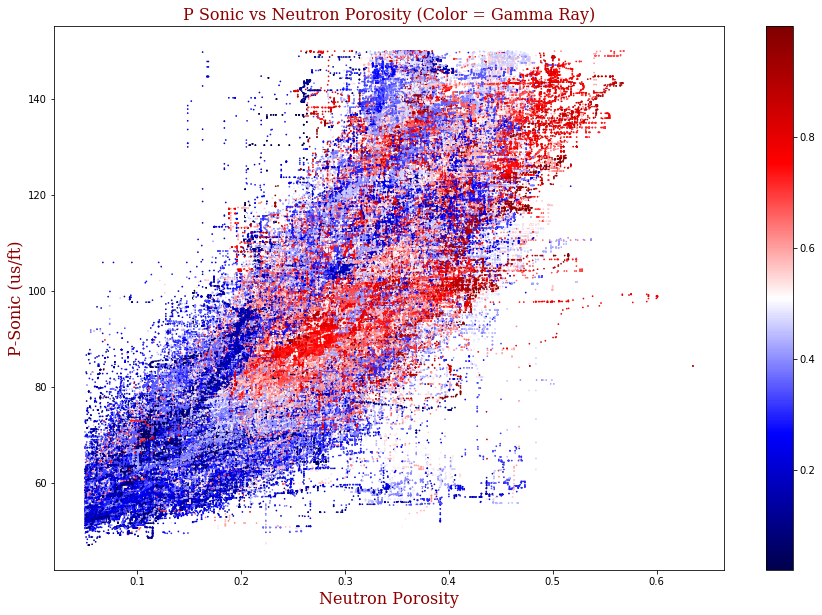

In [53]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

nphi_df.replace('',np.nan)
X = nphi_df[['RHOB','NPHI']]
#X = nphi_df[['NPHI']]
#X = nphi_df[['RHOB']]
y = nphi_df['DTC']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.5)


regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)

y_pred = regr.predict(X_test)

print("Coefficient: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print(X_test.head())

print(nphi_df.shape)
# Plot outputs


plt.figure(figsize = (15,10))
plt.title("P Sonic vs Neutron Porosity (Color = Gamma Ray)", fontdict=font)
plt.xlabel('Neutron Porosity', fontdict=font)
plt.ylabel('P-Sonic (us/ft)', fontdict=font)

plt.scatter(nphi_df.NPHI, nphi_df.DTC, c=nphi_df.GR, cmap='seismic', s=.5)
plt.colorbar()


plt.show()

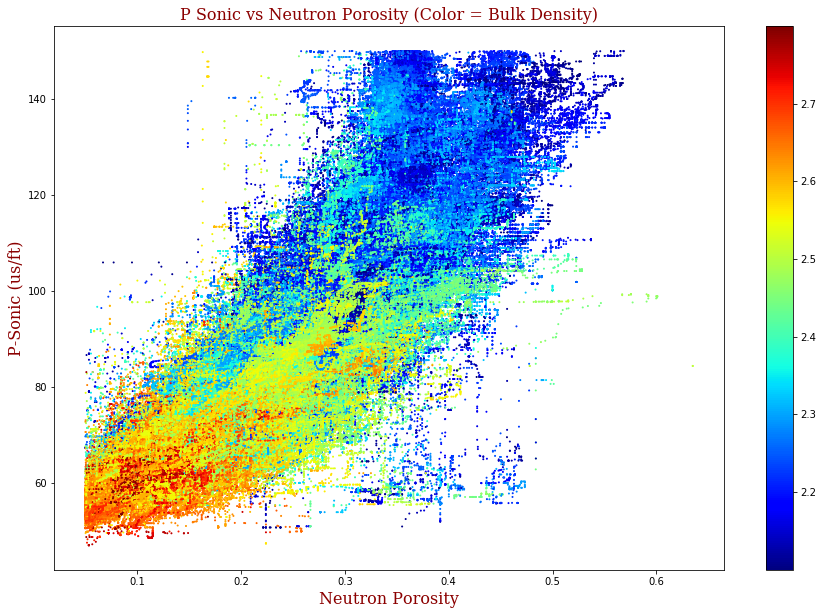

In [54]:

plt.figure(figsize = (15,10))
plt.title("P Sonic vs Neutron Porosity (Color = Bulk Density)", fontdict=font)
plt.xlabel('Neutron Porosity', fontdict=font)
plt.ylabel('P-Sonic (us/ft)', fontdict=font)

plt.scatter(nphi_df.NPHI, nphi_df.DTC, c=nphi_df.RHOB, cmap='jet', s=1)
plt.colorbar()


plt.show()

Coefficient: 
 [191.71847122]
Mean squared error: 117.31
Coefficient of determination: 0.75
            NPHI
800135  0.208000
750243  0.474556
539500  0.161978
630059  0.149985
134900  0.188522
(900018, 4)


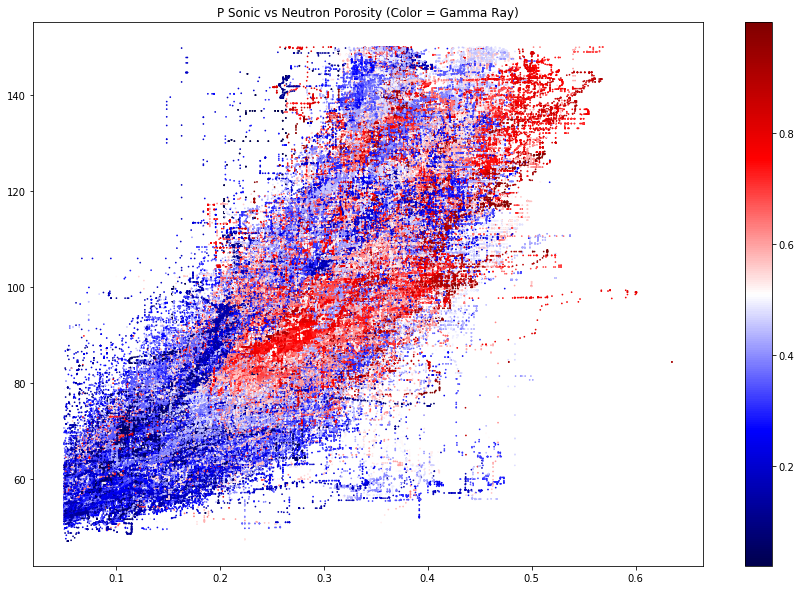

In [55]:
nphi_df.replace('',np.nan)
#X = nphi_df[['RHOB','NPHI']]
X = nphi_df[['NPHI']]
#X = nphi_df[['RHOB']]
y = nphi_df['DTC']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.5)


regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)

y_pred = regr.predict(X_test)

print("Coefficient: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print(X_test.head())
# Plot outputs
#fig = plt.figure()
#ax = plt.axes(projection='3d')

#zdata = y_pred
#xdata = X_test['NPHI']
#ydata = X_test['RHOB']

#ax.scatter3D(xdata,ydata,zdata)
#plt.scatter(X_test, y_test, color="black") #, cmap='rainbow')

#plt.plot(X_test, y_pred, color="blue", linewidth=3)

#plt.xticks(())
#plt.yticks(())

#plt.show()

print(nphi_df.shape)

plt.figure(figsize = (15,10))
plt.scatter(nphi_df.NPHI, nphi_df.DTC, c=nphi_df.GR, cmap='seismic', s=.5)
plt.colorbar()
plt.title("P Sonic vs Neutron Porosity (Color = Gamma Ray)")

plt.show()

[180.17689443   0.48988068]
[0.08803148 0.00034658]
0.7167161501596944


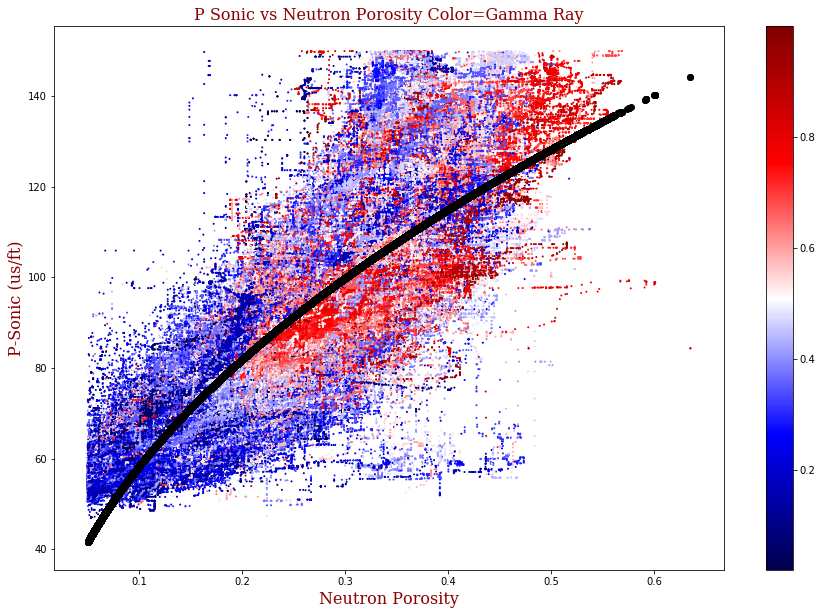

In [56]:
#curve fitting - power curve


pars, cov = curve_fit(f=pow_law, xdata=nphi_df['NPHI'], ydata=nphi_df['DTC'])
stdevs = np.sqrt(np.diag(cov))
par1 = sum((pow_law(nphi_df['NPHI'], *pars)-nphi_df['DTC'])**2)
par2 = sum((nphi_df['DTC']-np.mean(nphi_df['DTC']))**2)
r_square = 1 - (par1/par2)
print (pars)
print (stdevs)
print (r_square)


plt.figure(figsize = (15,10))
plt.title("P Sonic vs Neutron Porosity Color=Gamma Ray", fontdict=font)
plt.xlabel('Neutron Porosity', fontdict=font)
plt.ylabel('P-Sonic (us/ft)', fontdict=font)
plt.scatter(nphi_df.NPHI, nphi_df.DTC, c=nphi_df.GR, cmap='seismic', label='data', s=1)
plt.colorbar()
plt.scatter(nphi_df.NPHI, pow_law(nphi_df['NPHI'], *pars), color='black', label='trend')

plt.show()

[ 99.27000262 143.25311612  46.56977389]
[0.99256407 0.4983873  0.05801389]
0.750367738487073


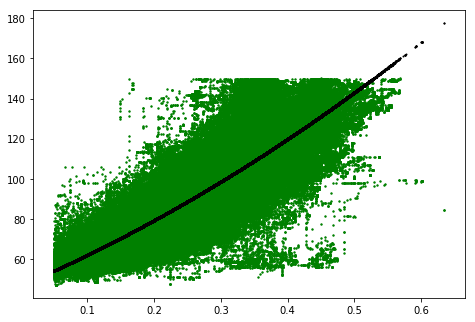

In [57]:
#curve fitting - second order polynomial curve


pars, cov = curve_fit(f=poly2, xdata=nphi_df['NPHI'], ydata=nphi_df['DTC'])
stdevs = np.sqrt(np.diag(cov))
par1 = sum((poly2(nphi_df['NPHI'], *pars)-nphi_df['DTC'])**2)
par2 = sum((nphi_df['DTC']-np.mean(nphi_df['DTC']))**2)
r_square = 1 - (par1/par2)
print (pars)
print (stdevs)
print (r_square)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(nphi_df['NPHI'], nphi_df['DTC'], s=2, color='green', label='Data')
#ax.plot(nphi_df['NPHI'], poly2(nphi_df['NPHI'], *pars), linestyle='-',linewidth=2)
ax.scatter(nphi_df['NPHI'], poly2(nphi_df['NPHI'], *pars), s=1, color='black',label='fit')

[-0.5415234   0.25996228]
                RHOB           NPHI            DTC             GR  \
count  900018.000000  900018.000000  900018.000000  900018.000000   
mean        2.432105       0.236985      87.030821       0.469333   
std         0.153233       0.097151      21.540914       0.188022   
min         2.100014       0.050006      47.016300       0.020003   
25%         2.304200       0.162747      70.334200       0.338520   
50%         2.469400       0.239513      83.343350       0.462348   
75%         2.556000       0.304211      99.413200       0.598950   
max         2.799889       0.635000     149.998900       0.999999   

             dt_gard     dt_predall       gard_err        all_err  
count  900018.000000  900018.000000  900018.000000  900018.000000  
mean       83.419953      86.899192       3.610868       0.131629  
std        22.648839      18.853606      15.739388      11.464270  
min        45.535298      41.531266     -91.395009     -68.220127  
25%        6

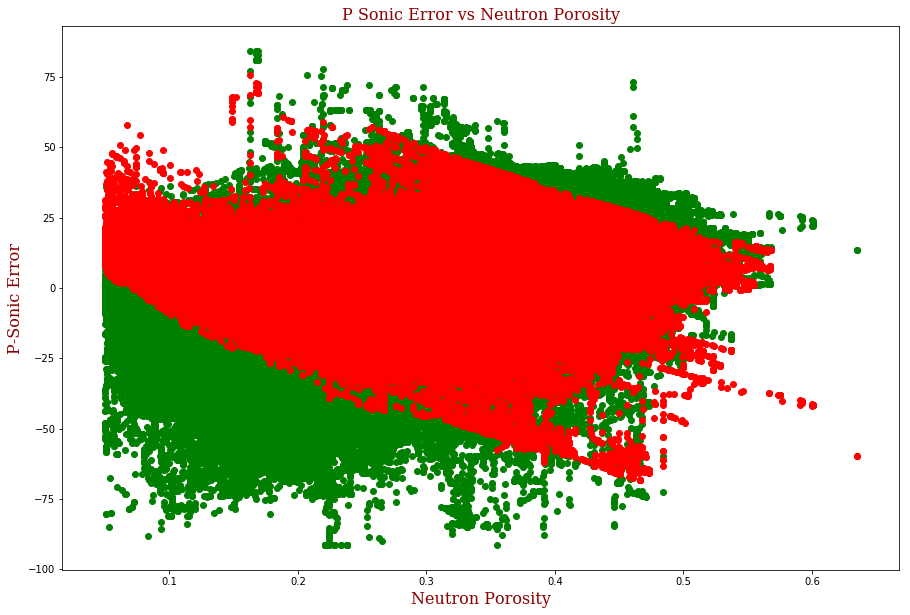

In [58]:
a = 180.17689443
b = 0.48988068


nphi_df['dt_gard'] = 1000000/(np.power((nphi_df['RHOB']/.23),(1/.25)))
#nphi_df['dt_gard'] = pow_law(nphi_df['RHOB'],(1/.23),4)

nphi_df['dt_predall'] = pow_law(nphi_df['NPHI'], a, b)
nphi_df['gard_err'] = nphi_df['DTC'] - nphi_df['dt_gard']
nphi_df['all_err'] = nphi_df['DTC'] - nphi_df['dt_predall']


pars, cov = curve_fit(f=line_solve, xdata=nphi_df['NPHI'], ydata=nphi_df['all_err'])
print (pars)

print(nphi_df.describe())


plt.figure(figsize = (15,10))
plt.title("P Sonic Error vs Neutron Porosity", fontdict=font)
plt.xlabel('Neutron Porosity', fontdict=font)
plt.ylabel('P-Sonic Error', fontdict=font)


plt.scatter(nphi_df.NPHI, nphi_df.gard_err, color='green', label='Gardner Error')
plt.scatter(nphi_df.NPHI, nphi_df.all_err, color='red', label='Morgan Error')
#plt.scatter(nphi_df.NPHI, line_solve(nphi_df['NPHI'], *pars), s=1, color='black',label='fit')
#plt.colorbar()


plt.show()

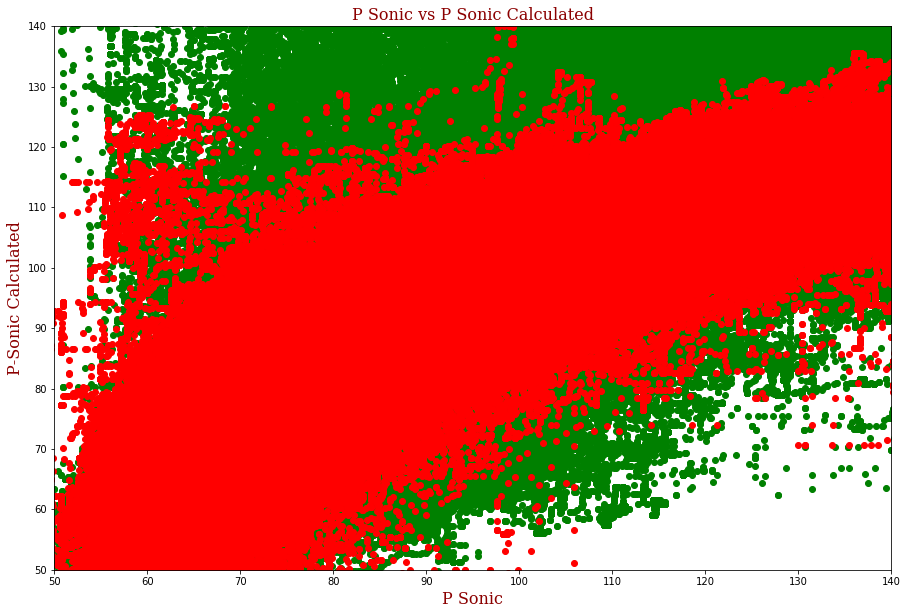

In [16]:
plt.figure(figsize = (15,10))
plt.title("P Sonic vs P Sonic Calculated", fontdict=font)
plt.xlabel('P Sonic', fontdict=font)
plt.ylabel('P-Sonic Calculated', fontdict=font)
plt.xlim([50,140])
plt.ylim([50,140])


plt.scatter(nphi_df.DTC, nphi_df.dt_gard, color='green', label='Gardner Error')
plt.scatter(nphi_df.DTC, nphi_df.dt_predall, color='red', label='Morgan Error')
#plt.scatter(nphi_df.NPHI, line_solve(nphi_df['NPHI'], *pars), s=1, color='black',label='fit')
#plt.colorbar()


plt.show()

[-7.85573973e-06  1.81566023e-06]
                RHOB           NPHI            DTC             GR  \
count  900018.000000  900018.000000  900018.000000  900018.000000   
mean        2.432105       0.236985      87.030821       0.469333   
std         0.153233       0.097151      21.540914       0.188022   
min         2.100014       0.050006      47.016300       0.020003   
25%         2.304200       0.162747      70.334200       0.338520   
50%         2.469400       0.239513      83.343350       0.462348   
75%         2.556000       0.304211      99.413200       0.598950   
max         2.799889       0.635000     149.998900       0.999999   

             dt_gard     dt_predall       gard_err       all_err  
count  900018.000000  900018.000000  900018.000000  9.000180e+05  
mean       83.419953      87.030821       3.610868 -4.583712e-08  
std        22.648839      18.659553      15.739388  1.076253e+01  
min        45.535298      53.981524     -91.395009 -9.321865e+01  
25%      

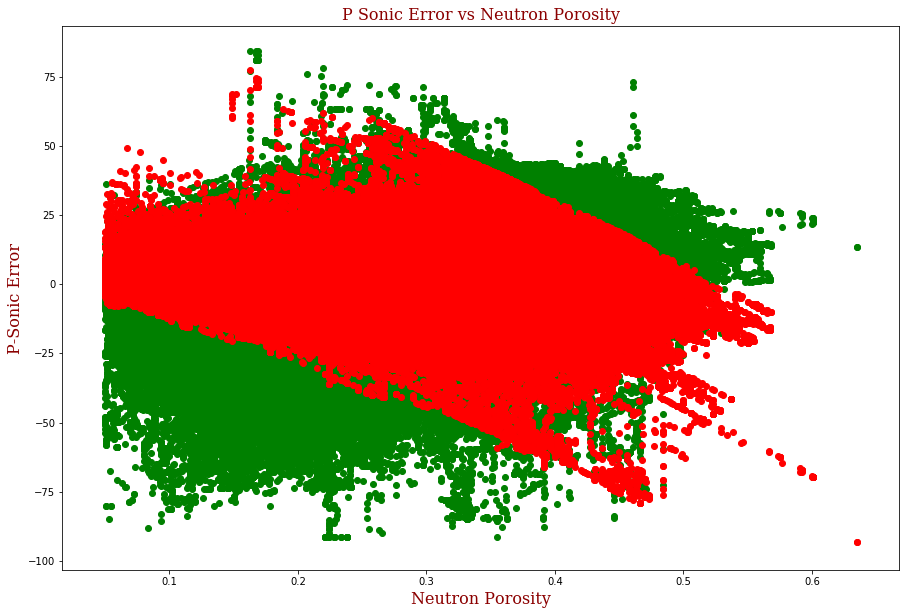

In [59]:
#second order polynomial

a = 99.27000262
b = 143.25311612
c = 46.56977389

nphi_df['dt_gard'] = 1000000/(np.power((nphi_df['RHOB']/.23),(1/.25)))
#nphi_df['dt_gard'] = pow_law(nphi_df['RHOB'],(1/.23),4)

nphi_df['dt_predall'] = poly2(nphi_df['NPHI'], a, b, c)
nphi_df['gard_err'] = nphi_df['DTC'] - nphi_df['dt_gard']
nphi_df['all_err'] = nphi_df['DTC'] - nphi_df['dt_predall']


pars, cov = curve_fit(f=line_solve, xdata=nphi_df['NPHI'], ydata=nphi_df['all_err'])
print (pars)

print(nphi_df.describe())


plt.figure(figsize = (15,10))
plt.title("P Sonic Error vs Neutron Porosity", fontdict=font)
plt.xlabel('Neutron Porosity', fontdict=font)
plt.ylabel('P-Sonic Error', fontdict=font)


plt.scatter(nphi_df.NPHI, nphi_df.gard_err, color='green', label='Gardner Error')
plt.scatter(nphi_df.NPHI, nphi_df.all_err, color='red', label='Morgan Error')
#plt.scatter(nphi_df.NPHI, line_solve(nphi_df['NPHI'], *pars), s=1, color='black',label='fit')
#plt.colorbar()


plt.show()

Reread files to get entire unfiltered dataset


In [75]:

print(len(files),'LAS files found.')

nphi_alias = ['NPHI','NEUT','CNPOR','NPOR']


depth_alias = ['DEPT','DEPTH','M_DEPTH','DPTH','DEPT:1','MD','DEPTH:1','DEPTH_HOLE','BDEP',
    'DMEA','TOTAL_DEPTH','TVD','DEP','TDEP','DEPTMEAS','DEPT_PNN','DEPT_CBL',
    '"DEPTH"','TVD:1','DEP:1']

#Make empty list and dataframe
err_files = []
nphi_df = pd.DataFrame()

#Place files that cause hangups here
hangups = []

#Saveout counter
i = 0
#k is a counter for suitable files
k = 0
#j is a counter for finding suitable logs i.e. those with nphi and dtc
j = 0
#Loop through files
for file in files:
    
    las = lasio.read(file)
    params = {'mnemonic' : [x.mnemonic for x in las.curves],
                  'unit' : [x.unit for x in las.curves]}
                  #'value' : [x.value for x in las.params],
                  #'descr' : [x.descr for x in las.params]}

    
    i += 1
    
    #print(las.well.WELL.value)
    #for item in las.well:
        #print(f"{item.descr} ({item.mnemonic}): {item.value}")
    j=0
    for count, curve in enumerate(las.curves):
        #temp = temp[temp.mnemonic.isin(nphi_alias)]
        #print(temp)
        #print(f"Curve: {curve.mnemonic}, Units: {curve.unit}, Description: {curve.descr}")
        if curve.mnemonic == 'GR' or curve.mnemonic == 'GRN' or curve.mnemonic == 'GRR' or curve.mnemonic == 'GR_BPX_GOLD':
            j += 1
            curve.mnemonic = 'GR'
        if curve.mnemonic == 'NPHI' or curve.mnemonic == 'NPHIL' or curve.mnemonic == 'NEUT' or curve.mnemonic == 'CNPOR':# or curve.mnemonic == 'NPOR' or curve.mnemonic == 'NPHI_BPX_GOLD':
            #print(f"Curve: {curve.mnemonic}, Units: {curve.unit}, Description: {curve.descr}")
            j += 1
            curve.mnemonic = 'NPHI'
        if curve.mnemonic == 'DTC' or curve.mnemonic == 'DT' or curve.mnemonic == 'DTCO_BPX_GOLD':
            curve.mnemonic = 'DTC'
            #print(file,f"Curve: {curve.mnemonic}, Units: {curve.unit}, Description: {curve.descr}")
            j += 1
        if curve.mnemonic == 'RHOB' or curve.mnemonic == 'RHOB_BPX_GOLD' or curve.mnemonic == 'RHOZ':
            curve.mnemonic = 'RHOB'
            #print(file,f"Curve: {curve.mnemonic}, Units: {curve.unit}, Description: {curve.descr}")
            j += 1
            #print (j)
    if j == 4:
        temp = pd.DataFrame(params)
        #temp['API'] = las.well.API.value
        temp['file'] = file.split('/')[-1]
        temp['well'] = las.well.WELL.value
        welltmp = las.df()
        navg = welltmp['NPHI'].mean()
        #print ("Nphi avg =",navg)
        if navg > 1:
            welltmp['NPHI'] = welltmp['NPHI']/100
        welltmp['GR'] = signal.medfilt(welltmp['GR'], kernel_size=41)
        welltmp['GR'] = (welltmp['GR']-np.min(welltmp['GR']))/(np.max(welltmp['GR'])-np.min(welltmp['GR']))
        #welltmp['NPHI'] = signal.medfilt(welltmp['NPHI'], kernel_size=41)
        #welltmp['RHOB'] = signal.medfilt(welltmp['RHOB'], kernel_size=41)
        #welltmp['DTC'] = signal.medfilt(welltmp['DTC'], kernel_size=41)
        welltmp_new = welltmp[['RHOB','NPHI', 'DTC', 'GR']]
        welltmp_new1 = welltmp_new[(welltmp_new.RHOB < 4) & (welltmp_new.RHOB > 1) & (welltmp_new.DTC > 10) & (welltmp_new.DTC < 300) & (welltmp_new.NPHI > 0)  ]
        welltmp_drop = welltmp_new1.dropna(subset=['RHOB', 'NPHI', 'DTC', 'GR'],axis=0, how='any')
        welltmp_drop.replace('',np.nan)
        #print (file,welltmp_drop.head())
        #print (file)
        nphi_df = pd.concat([nphi_df,welltmp_drop],ignore_index=True)
        k += 1
        if k%100 == 0:
            print(k)
    
  
print(f"There are a total of: {k} files with both NPHI and DTC")

#Calculate New DTC for comparison
nphi_df.replace('',np.nan)

a = 180.17689443
b = 0.48988068


nphi_df['dt_gard'] = 1000000/(np.power((nphi_df['RHOB']/.23),(1/.25)))
#nphi_df['dt_gard'] = pow_law(nphi_df['RHOB'],(1/.23),4)

nphi_df['dt_predall'] = pow_law(nphi_df['NPHI'], a, b)
nphi_df['gard_err'] = nphi_df['DTC'] - nphi_df['dt_gard']
nphi_df['all_err'] = nphi_df['DTC'] - nphi_df['dt_predall']

e = 99.27000262
f = 143.25311612
g = 46.56977389

nphi_df['dt_poly'] = poly2(nphi_df['NPHI'], e, f, g)

nphi_df.replace('',np.nan)
nphi_df['poly_err'] = nphi_df['DTC'] - nphi_df['dt_poly']

#pars, cov = curve_fit(f=line_solve, xdata=nphi_df['NPHI'], ydata=nphi_df['all_err'])
#print (pars)

print(nphi_df.describe())


172 LAS files found.


Header section Parameter regexp=~P was not found.


100


Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.
Found nonstandard LAS section: ~Tops	Information	Section
Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.


There are a total of: 162 files with both NPHI and DTC
               RHOB          NPHI           DTC            GR       dt_gard  \
count  1.171426e+06  1.171426e+06  1.171426e+06  1.171426e+06  1.171426e+06   
mean   2.299145e+00  2.487956e-01  9.138156e+01  4.584137e-01  1.643350e+02   
std    3.511948e-01  1.179380e-01  2.748806e+01  1.889294e-01  2.773455e+02   
min    1.000100e+00  2.000000e-06  1.011330e+01  0.000000e+00  1.116614e+01   
25%    2.175000e+00  1.641920e-01  7.088553e+01  3.234149e-01  6.683124e+01   
50%    2.391000e+00  2.548545e-01  8.681005e+01  4.501413e-01  8.562351e+01   
75%    2.543800e+00  3.290000e-01  1.064862e+02  5.892957e-01  1.250473e+02   
max    3.978800e+00  1.460200e+00  2.999630e+02  1.000000e+00  2.797291e+03   

         dt_predall      gard_err       all_err       dt_poly      poly_err  
count  1.171426e+06  1.171426e+06  1.171426e+06  1.171426e+06  1.171426e+06  
mean   8.780282e+01 -7.295345e+01  3.578740e+00  8.973604e+01  1.645517e+00  

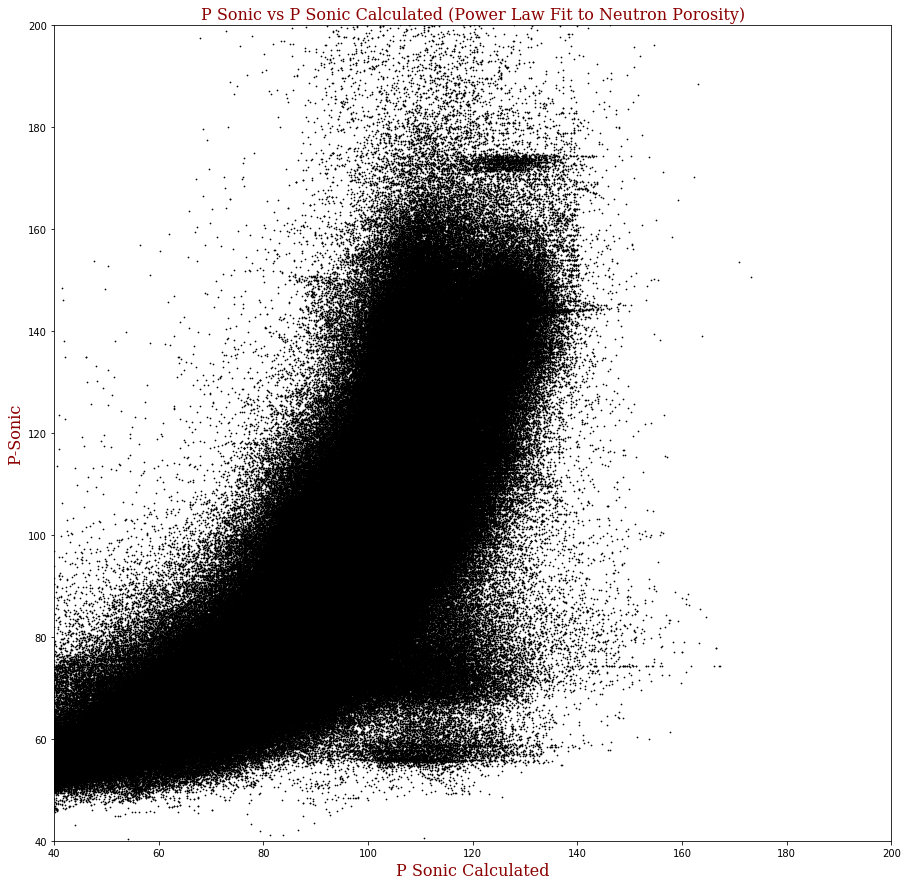

In [72]:
plt.figure(figsize = (15,15))
plt.title("P Sonic vs P Sonic Calculated (Power Law Fit to Neutron Porosity)", fontdict=font)
plt.xlabel('P Sonic Calculated', fontdict=font)
plt.ylabel('P-Sonic', fontdict=font)
plt.xlim([40,200])
plt.ylim([40,200])


#plt.scatter(nphi_df.dt_gard, nphi_df.DTC, color='green', label='Gardner', s=.5)
plt.scatter(nphi_df.dt_predall, nphi_df.DTC, color='black', label='Morgan', s=.5)
#plt.scatter(nphi_df.NPHI, line_solve(nphi_df['NPHI'], *pars), s=1, color='black',label='fit')
#plt.colorbar()



plt.show()

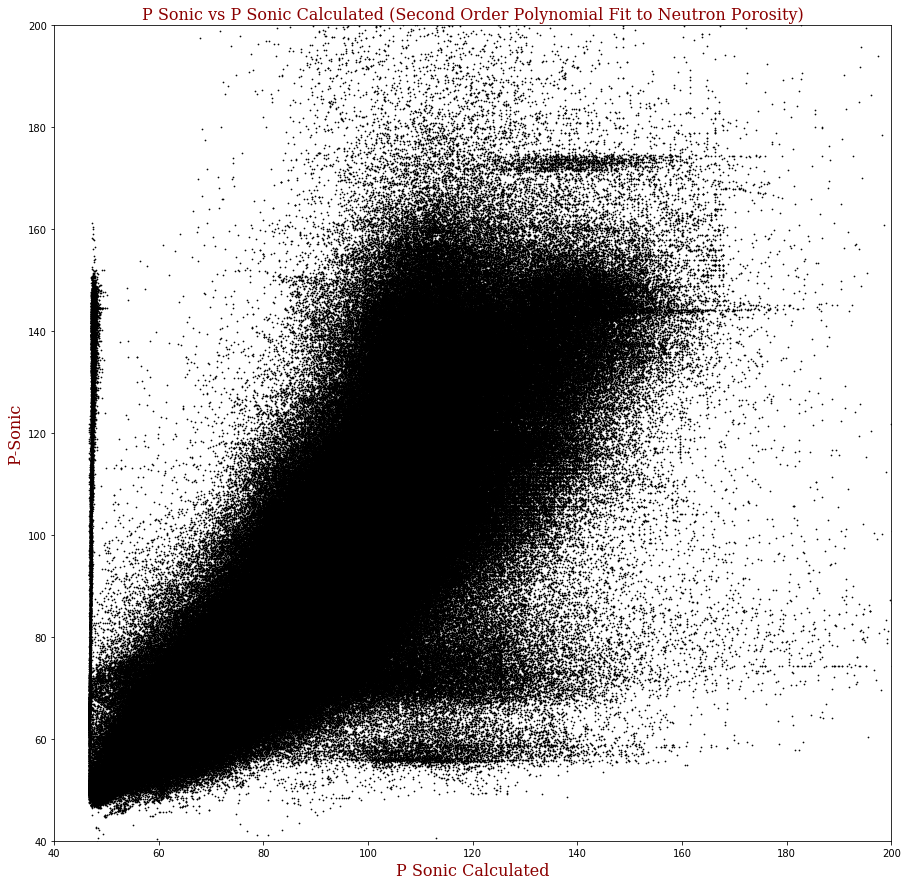

In [73]:
plt.figure(figsize = (15,15))
plt.title("P Sonic vs P Sonic Calculated (Second Order Polynomial Fit to Neutron Porosity)", fontdict=font)
plt.xlabel('P Sonic Calculated', fontdict=font)
plt.ylabel('P-Sonic', fontdict=font)
plt.xlim([40,200])
plt.ylim([40,200])


#plt.scatter(nphi_df.dt_gard, nphi_df.DTC, color='green', label='Gardner', s=.5)
plt.scatter(nphi_df.dt_poly, nphi_df.DTC, color='black', label='Morgan', s=.5)
#plt.scatter(nphi_df.NPHI, line_solve(nphi_df['NPHI'], *pars), s=1, color='black',label='fit')
#plt.colorbar()



plt.show()

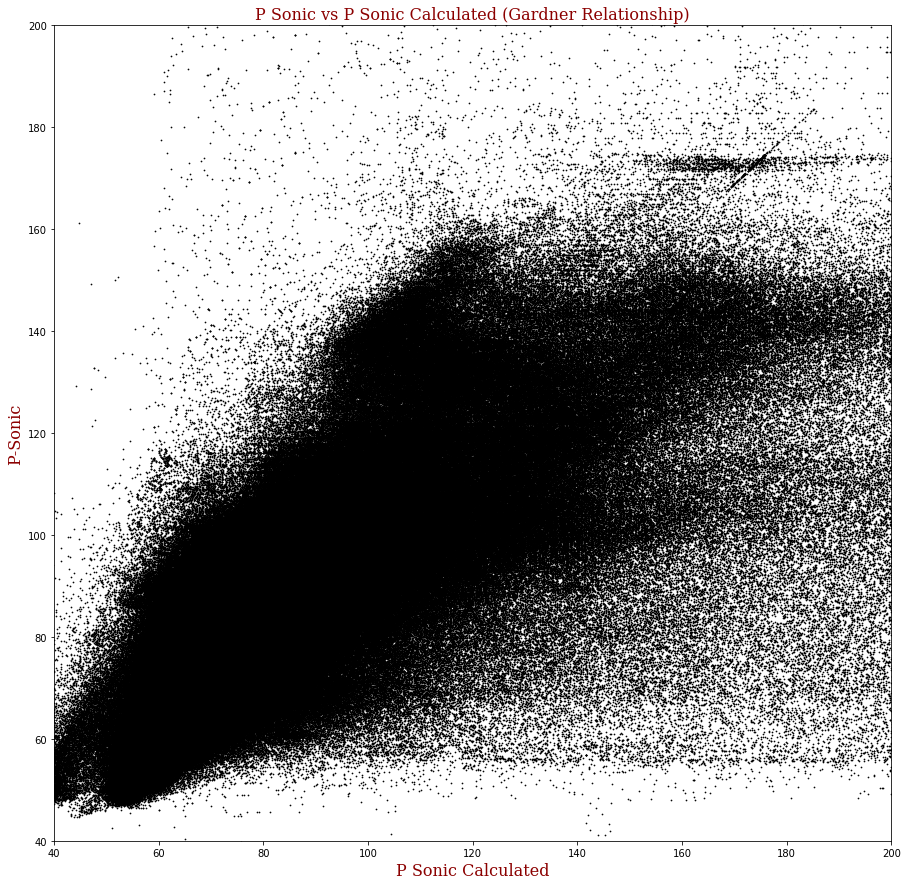

In [74]:
plt.figure(figsize = (15,15))
plt.title("P Sonic vs P Sonic Calculated (Gardner Relationship)", fontdict=font)
plt.xlabel('P Sonic Calculated', fontdict=font)
plt.ylabel('P-Sonic', fontdict=font)
plt.xlim([40,200])
plt.ylim([40,200])


plt.scatter(nphi_df.dt_gard, nphi_df.DTC, color='black', label='Gardner', s=.5)
#plt.scatter(nphi_df.dt_predall, nphi_df.DTC, color='red', label='Morgan', s=.5)
#plt.scatter(nphi_df.NPHI, line_solve(nphi_df['NPHI'], *pars), s=1, color='black',label='fit')
#plt.colorbar()



plt.show()